# **Deep Q-Network Route Finder**

Here in this jupyter notebook, we will have some fun with using reinforcement learning to find safe routes across the ice.
This notebook draws a lot of inspiration from Open AI's [FrozenLake](https://gym.openai.com/envs/FrozenLake8x8-v0/) gym environment.
Really, how nice of them to have a well crafted toy problem already thought out for us!

Specifically and technically, we will train a Deep Q-Network in Keras/Tensorflow to help us decide safe routes across slippery ice!
Later, we will move on to applying this safe navigation tool to our crevasse avoidance problem.

References:
- Open AI [gym](https://github.com/openai/gym) 
- [Simple Reinforcement Learning with Tensorflow Part 0: Q-Learning with Tables and Neural Networks](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0)
- [Simple Reinforcement Learning with Tensorflow Part 4: Deep Q-Networks and Beyond](https://medium.com/@awjuliani/simple-reinforcement-learning-with-tensorflow-part-4-deep-q-networks-and-beyond-8438a3e2b8df)
- [Frozen Lake github gist using Keras](https://gist.github.com/ceshine/eeb97564c21a77b8c315179f82b3fc08)
- [Reinforcement Learning w/ Keras + OpenAI: DQNs](https://towardsdatascience.com/reinforcement-learning-w-keras-openai-dqns-1eed3a5338c)
- [Introduction to Various Reinforcement Learning Algorithms. Part I (Q-Learning, SARSA, DQN, DDPG)](https://towardsdatascience.com/introduction-to-various-reinforcement-learning-algorithms-i-q-learning-sarsa-dqn-ddpg-72a5e0cb6287)

In [1]:
# Import all the necessary libraries
import os
import random
import sys
import warnings
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  #set to see only the first gpu
os.environ['KERAS_BACKEND'] = 'tensorflow'
warnings.simplefilter(action = "ignore", category = FutureWarning)

import matplotlib.pyplot as plt
import matplotlib.patches
import numpy as np
import rasterio
%matplotlib inline

import gym
from gym.utils import seeding
import quilt

import keras
import tensorflow as tf
import rl
#import hyperopt

from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Conv2D, Flatten, Dense, Input, SeparableConv2D
from keras.layers.core import Activation, Flatten, Dropout, Reshape
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory
#from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', tf.__version__)
tf.test.gpu_device_name()

Using TensorFlow backend.


Python       : 3.6.5 | packaged by conda-forge | (default, Apr  6 2018, 13:39:56) 
Numpy        : 1.14.2
Keras        : 2.1.5
Tensorflow   : 1.4.1


'/device:GPU:0'

In [2]:
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)
tf.set_random_seed(seed=seed)

## Design Keras Model to fit into Q-Network

In [3]:
def keras_convnet(input_shape=(8,8,1)):
    """
    The Keras Convolutional Network that parses the incoming pixel data.
    Based on Mnih et al. 2015's "Playing Atari with Deep Reinforcement Learning" paper
    Consists of 2 Convolutional Layers, and 1 Dense Layer, plus 1 Linear output Layer
    
    Inputs:
    input_shape -- shape of the input tensor, (height, width, channels)
    
    Outputs:
    model -- keras.models.Model instance
    
    """
    inp = Input(shape=input_shape)
    assert(inp.shape.ndims == 4)  #needs to be shape like (?,4,4,1) for 4x4 grid, (?,8,8,1) for 8x8 grid
        
    X = Conv2D(filters=16, kernel_size=(8,8), strides=(4,4), padding='same', activation='relu')(inp)
    X = Conv2D(filters=32, kernel_size=(4,4), strides=(2,2), padding='same', activation='relu')(X)
    X = Flatten()(X)
    X = Dense(units=256, activation='relu')(X)
    X = Dense(units=4, activation='linear')(X)
    
    model = Model(inputs=inp, outputs=X) 
    
    return model

# CrevasseCrosser gym environment

## Implement our own CrevasseCrosser class based on OpenAI FrozenLake gym

Borrows some elements from https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py

**Note**: There are a lot of Python classes wrapping functions to implement this CrevasseCrosserEnv (read: can be hard to follow if you're not familiar with the OpenAI gym). If you are looking for the previous pure numpy implementation that more clearly illustrates the mechanics, you can check out an older version at this [git commit](https://github.com/weiji14/nz_space_challenge/blob/11c293a1c30029b4717c0e40111c56f047dea3c0/route_finder.ipynb).

### Load map grid environment (the crevasse laden terrain our virtual player will be crossing) from quilt

In [4]:
quilt.install(package='weiji14/nz_space_challenge', hash='747479b4', force=True)

100%|██████████| 541M/541M [00:00<00:00, 61.3GB/s]

(3616, 7200, 1)


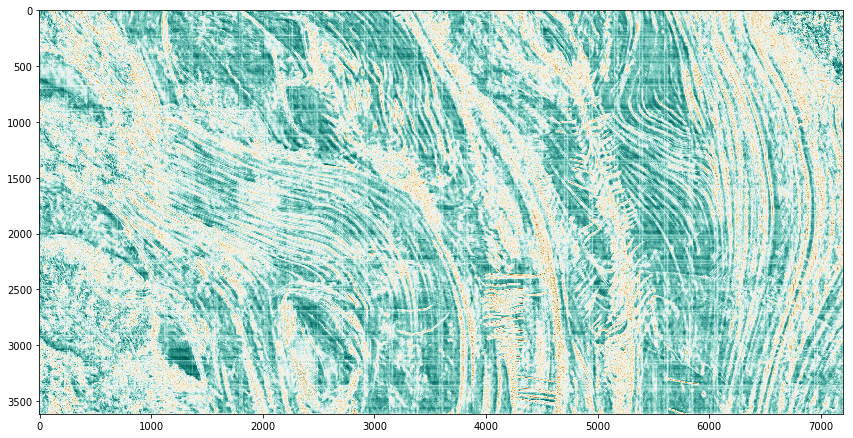

In [5]:
from quilt.data.weiji14 import nz_space_challenge
#map_grid_environment = np.load(file=nz_space_challenge.test.W_hat_data())
with rasterio.open(fp=nz_space_challenge.test.crevasse_map()) as raster_source:
    map_env = raster_source.read(indexes=list(range(1,raster_source.count+1)), masked=True)  #outputs a masked numpy array of shape (1, height, width)
    map_env = np.rollaxis(a=map_env, axis=0, start=3)   #change to shape (height, width, 1)
    print(map_env.shape)

fig, axarr = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(14.4,9.6))
axarr[0, 0].imshow(-map_env[:,:,0], cmap='BrBG')

In [6]:
get_xy = lambda x, y: rasterio.transform.xy(transform=raster_source.transform, cols=x, rows=y)  #transform image coordinates to geographic xy coordinates
get_xy(0, 1)

(-674325.0, -718925.0)

### **CrevasseCrosser** custom OpenAI gym environment class!

In [7]:
#https://stackoverflow.com/questions/45068568/is-it-possible-to-create-a-new-gym-environment-in-openai/47132897#47132897
class CrevasseCrosserEnv(gym.Env):
    """
    An OpenAI gym compatible custom environment inspired from the FrozenLake env!
    
    The map should be a 2D numpy array, with values on each xy position indicating the
    penalty for stepping on to that position. The centre pixels, specifically a 2x2 square,
    will be where our player is assumed to be located. Moving around the map environment 
    is done using a scrolling method, similar to classic RPG games! Not sure if I explained
    this intuitively enough :P
    
    Anyways, E.g. if values range from 0 to 1
    Values close to '1' would indicate a hole or 'H' in the FrozenLake env
    Values close to '0' would indicate the goal or 'G' in the FrozenLake env
    Values in between '0.25-0.75' would be the free spot or 'F' in the FrozenLake env, note that we penalize steps!
    There is not really a starting point 'S', we always assume the player is in the centre
    """
    
    def __init__(self, map_env:np.ndarray=None, observation_window:tuple=(8,8,1)):
        
        self.map_env = map_env
        assert(isinstance(self.map_env, np.ndarray))  #check that we are passing in a numpy array
        assert(map_env.ndim==3)  #check that we have a map_env of shape (height, width, channels)
                
        self.observation_window = observation_window
        assert(len(self.observation_window) == 3)  #check that we have a observation window of shape (height, width, channels)
        assert(self.observation_window[0]%2 == 0)  #check that our observation window height is an even number
        assert(self.observation_window[1]%2 == 0)  #check that our observation window width is an even number
        
        self.map_env_shape = self.map_env.shape    #create an alias to the map_env shape
        assert(self.map_env_shape[-1] == self.observation_window[-1])  #check that the no. of channels in our map_env matches the no. of channels in our observation_window
        assert(self.map_env_shape[-1] == 1)  #check that we only have a one band/channel input, TODO remove when moving to more bands!
        
        self.gameover = None  #boolean setting to store whether game round is over
        self.observation_bbox = {'pixel_y0':None, 'pixel_x0': None, 'pixel_y1': None, 'pixel_x1': None}  #initialize this observation_bbox variable
        self.current_observation = self.reset()   #reset our current observation to a random initial state
        
        ## number of Actions (discrete)
        ## Define what our agent can do, i.e. move left, down, right, up
        self.nA = 4
        self.action_space = gym.spaces.Discrete(self.nA)
    
    def reset(self):
        """
        Function to reset the entire environment
        Sets our player at some random place on the map
        """
        self.lastaction = None
        self.gameover = False
        
        window_height, window_width, _ = self.observation_window
        
        ## Get random x and y positions (image coordinates) from the map_env that are not too close to the border
        pixel_y0 = np.random.randint(low=0+self.observation_window[0], high=map_env.shape[0]-2*self.observation_window[0])
        pixel_x0 = np.random.randint(low=0+self.observation_window[1], high=map_env.shape[1]-2*self.observation_window[1])
        
        self.current_observation, self.observation_bbox = self.set_observation(pixel_y0=pixel_y0, pixel_x0=pixel_x0)
        assert(self.current_observation.shape == self.observation_window)
        
        return self.current_observation  #return initial observation
    
    def set_observation(self, pixel_y0, pixel_x0):
        
        pixel_y1 = pixel_y0+self.observation_window[0]
        pixel_x1 = pixel_x0+self.observation_window[1]
        
        observation = self.map_env[pixel_y0:pixel_y1, pixel_x0:pixel_x1, :]
        observation_bbox = {'pixel_y0': pixel_y0, 'pixel_x0': pixel_x0, 'pixel_y1': pixel_y1, 'pixel_x1': pixel_x1}
        
        return observation, observation_bbox
    
    def step(self, action):
        """
        Moves our player around the environment by applying an action
        
        Returns:
        (observation, reward, done, info)
        """
        if self.gameover == True:
            return (self.current_observation, 0, True, {})
        
        ## Get new observation
        new_pixel_y0 = self.observation_bbox['pixel_y0']
        new_pixel_x0 = self.observation_bbox['pixel_x0']
        new_pixel_y1 = self.observation_bbox['pixel_y1']
        new_pixel_x1 = self.observation_bbox['pixel_x1']
        
        if action == 0: #Left <-
            new_pixel_x0 = max(new_pixel_x0-1, 0)
        elif action == 1: #Down v
            new_pixel_y0 = min(new_pixel_y1+1, self.map_env_shape[0]) - self.observation_window[0]
        elif action == 2: #Right ->
            new_pixel_x0 = min(new_pixel_x1+1, self.map_env_shape[1]) - self.observation_window[1]
        elif action == 3: # Up ^
            new_pixel_y0 = max(new_pixel_y0-1, 0)
        
        self.current_observation, self.observation_bbox = self.set_observation(pixel_y0=new_pixel_y0, pixel_x0=new_pixel_x0)
        assert(self.current_observation.shape == self.observation_window)
        
        ## Get reward from centre 2x2 grid square
        midsquare_y0 = int((self.observation_bbox['pixel_y0'] + self.observation_bbox['pixel_y1'])/2 - 1)
        midsquare_y1 = int(midsquare_y0 + 2)
        midsquare_x0 = int((self.observation_bbox['pixel_x0'] + self.observation_bbox['pixel_x1'])/2 - 1)
        midsquare_x1 = int(midsquare_x0 + 2)
                
        midsquare_vals = self.map_env[midsquare_y0:midsquare_y1,
                                      midsquare_x0:midsquare_x1, :]
        midsquare_max = np.max(midsquare_vals)  #get maximum of the midsquare pixels
        reward = -midsquare_max  #reward is negative integer as it is a penalty!
        
        ## Get done (or not) status
        _, bin_edges = np.histogram(a=self.current_observation, bins=4)  #split current_observation into four quartiles
        _, lower_quartile, median, upper_quartile, _ = bin_edges
        
        if midsquare_max > lower_quartile and midsquare_max < upper_quartile: #if in a free spot
            done = False
        elif midsquare_max >= upper_quartile:  #i.e. if we're in a crevasse!
            done = self.gameover = True
        elif midsquare_max <= lower_quartile:  #i.e. we've reached the goal!
            difficulty = np.sum(self.current_observation)  #sum of all the pixels give indication of difficulty of map
            bonus = (difficulty/np.product(a=self.observation_window)) * 20  #modulate the bonus with size of observation_window
            reward += bonus  #give a bonus of a few points related to difficulty of the map
            done = self.gameover = True
        else:
            raise ValueError(f"unknown midsquare_max value {midsquare_max} that doesn't fit in {bin_edges}")
        
        ## Get info about coordinates of midpoint
        info = {"coordinates": ('x','y')}

        self.lastaction = action
        return (self.current_observation, reward, done, info)
    
    def render(self, mode='human'):
        """
        Matplotlib function to plot the current observation window
        with the player position in the middle as a 2x2 grid box
        """
        fig, axarr = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(2,2))
        #axarr[0, 0].imshow(X=self.player_position[:,:,0], cmap='winter')
        axarr[0, 0].imshow(X=-self.current_observation[:,:,0], cmap='BrBG')
        upper_left_y = self.observation_window[0]/2 - 1 - 0.5 
        upper_left_x = self.observation_window[1]/2 - 1 - 0.5
        axarr[0, 0].add_patch(matplotlib.patches.Rectangle(xy=(upper_left_x,upper_left_y),
                                                           width=2,
                                                           height=2,
                                                           fill=False,
                                                           edgecolor='red',
                                                           linewidth=2))
        
        if self.lastaction is not None:
            print("  ({})".format(["Left","Down","Right","Up"][self.lastaction]))
        else:
            print("")
        return plt.show()
    
    def seed(self, seed=None):
        """
        Just a simple function to set the seed of our gym environment
        """
        self.np_random, seed = gym.utils.seeding.np_random(seed=seed)
        return [seed]

### Crevasse Environment Processor

In [8]:
# Refer to https://github.com/keras-rl/keras-rl/blob/master/examples/dqn_atari.py
from rl.core import Processor

class CrevasseEnvProcessor(Processor):
    """
    This processor takes the env observation (index position of the player)
    and returns a stacked 2 channel 2D array of shape (?, height, width, 2)
    containing the player position (channel 1) and the map grid (channel 2)
    """        
    def process_state_batch(self, batch):
        #print("b", batch.shape, batch.ndim, batch)
        assert(batch.ndim > 4)
        processed_batch = np.concatenate(batch, axis=0)
        #print("pb", processed_batch.shape)
        assert(processed_batch.ndim == 4)
        #assert(processed_batch.shape == (1,8,8,2))
        return processed_batch

### Callback to plot reward and number steps taken per episode

In [9]:
# See also https://github.com/keras-rl/keras-rl/blob/master/rl/callbacks.py
from keras.callbacks import Callback

class plot_reward_and_steps(Callback):
    def __init__(self, plot_interval:int=200, figsize=(15,3)):
        super().__init__()
        self.figsize = figsize                   #size of each subplot
        self.plot_interval = int(plot_interval)  #the number of episodes that elapsed when we want to plot a graph, default=200
        self.episode_count = 0                   #counter that keeps track of no. of episodes that have passed
        self.logs_list = []                      #Python list to store all our log information!
        
    def on_episode_end(self, episode, logs={}):
        self.logs_list.append(logs.copy())      #append log info into logs_list
        self.episode_count += 1                 #add 1 to episode_count
        
        if self.episode_count % self.plot_interval == 0:  #when our episode_count divided by the plot_interval has remainder of 0
           
            stepsList = [log['nb_episode_steps'] for log in self.logs_list]
            rewardList = [log['episode_reward'] for log in self.logs_list]
            
            fig, axarr = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=self.figsize)
            axarr[0, 0].plot(rewardList[-self.plot_interval:], color='blue')  #plot to see e.g. last 200 rewardTallies
            axarr[0, 0].set_title('Reward Tally over each episode')
            #axarr[0, 0].set_ylim([-7.5,7.5])
            axarr[0, 1].plot(stepsList[-self.plot_interval:], color='orange')  #plot to see e.g. last 200 number of steps taken
            axarr[0, 1].set_title('No. of steps taken over each episode')
            #axarr[0, 1].set_ylim([0,100])
            plt.show();
            
            self.logs = []    #clear our logs_list

# Setup the training environment

In [10]:
env = CrevasseCrosserEnv(map_env=map_env)
env.seed(seed=seed)

[42]

  (Left)


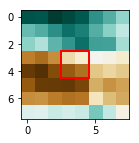

[42] -0.21101517975330353 True {'coordinates': ('x', 'y')}


In [11]:
#Unit tests
env.reset()
observation, reward, done, info = env.step(env.action_space.sample())
env.render()
print(_, reward, done, info)

### Build and compile the Deep Q-Network(DQN) model

Referred to implementation at https://github.com/keras-rl/keras-rl/blob/master/examples/dqn_atari.py

In [12]:
# Arguments to pass into dqn_model.fit
episodes = 1000               #rough number of episodes we want to train the model on
nb_max_episode_steps = 50     #maximum number of steps per episode before stopping the player

# Assuming an episode finishes in a quarter of the max_episode_steps
nb_steps= episodes * (nb_max_episode_steps/4)   #number of steps corresponding to roughly 1200 episodes
log_interval = 200 * (nb_max_episode_steps/4)   #print log data for roughly every +/-200 episodes

In [13]:
## Keras Model parameters
optimizer = keras.optimizers.Adam(lr=0.001)
model = keras_convnet(input_shape=(8,8,1))
plot_info = plot_reward_and_steps(plot_interval=250, figsize=(15, 3))

## Deep Q-Network parameters
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1.0, value_min=0.1, value_test=0.05, nb_steps=nb_steps)
processor = CrevasseEnvProcessor()
nb_actions = env.action_space.n
memory = SequentialMemory(limit=1000, window_length=1)

## Compile the DQN Agent
dqn_model = DQNAgent(model=model, policy=policy,
                     memory=memory, processor=processor,
                     nb_actions=nb_actions, nb_steps_warmup=50,
                     batch_size=32, target_model_update=100,
                     enable_double_dqn=True, enable_dueling_network=True)
dqn_model.compile(optimizer=optimizer)
dqn_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8, 8, 1)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 16)          1040      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 32)          8224      
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8448      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
_________________________________________________________________
lambda_1 (Lambda)            (None, 4)                 0         
Total para

### **Train the Deep Q-Network iteratively here**

Training for ~1000 episodes with max 50 steps, logging every 2500.0 steps
Training for 12500.0 steps ...
Interval 1.0 (0 steps performed)
1934/2500 [======================>.......] - ETA: 22s - reward: -0.1196

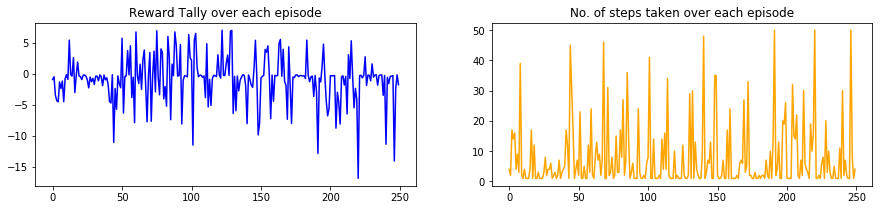

2500/2500 [==============================] - 87s 35ms/step - reward: -0.1094
322 episodes - episode_reward: -0.849 [-16.860, 7.213] - loss: 0.400 - mean_q: -0.391 - mean_eps: 0.908

Interval 2.0 (2500 steps performed)
1178/2500 [=============>................] - ETA: 23s - reward: -0.0020

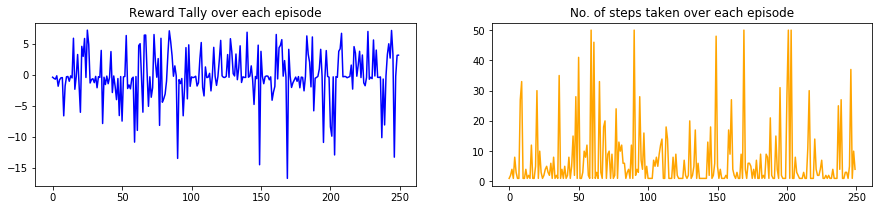

2500/2500 [==============================] - 45s 18ms/step - reward: -0.0260
345 episodes - episode_reward: -0.175 [-16.754, 7.162] - loss: 0.405 - mean_q: 1.038 - mean_eps: 0.730

Interval 3.0 (5000 steps performed)
 583/2500 [=====>........................] - ETA: 33s - reward: 0.0805

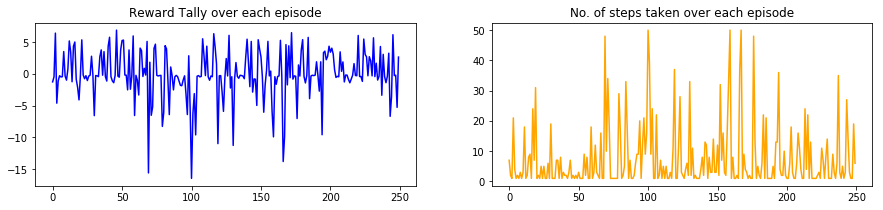

2500/2500 [==============================] - 44s 17ms/step - reward: 0.0534
274 episodes - episode_reward: 0.492 [-14.202, 7.118] - loss: 0.225 - mean_q: 2.492 - mean_eps: 0.550

Interval 4.0 (7500 steps performed)
 501/2500 [=====>........................] - ETA: 32s - reward: 0.0235

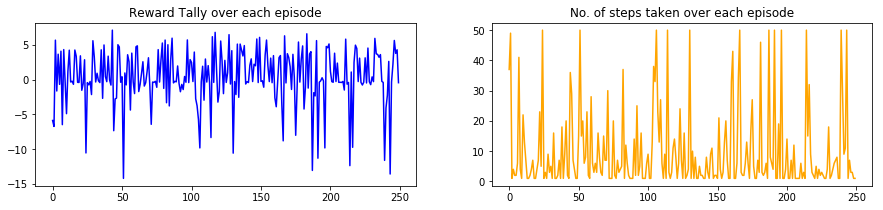

2500/2500 [==============================] - 43s 17ms/step - reward: 0.1200
294 episodes - episode_reward: 1.000 [-13.573, 7.649] - loss: 0.322 - mean_q: 1.636 - mean_eps: 0.370

Interval 5.0 (10000 steps performed)
  70/2500 [..............................] - ETA: 51s - reward: 0.5763

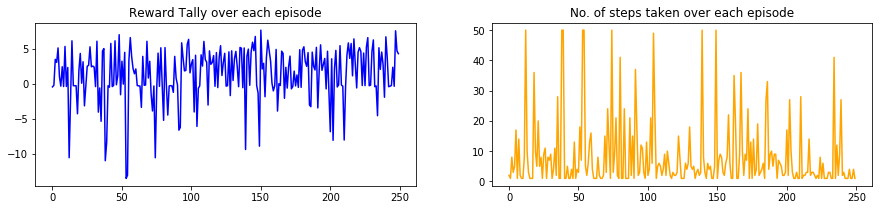

2103/2500 [========================>.....] - ETA: 6s - reward: 0.2026

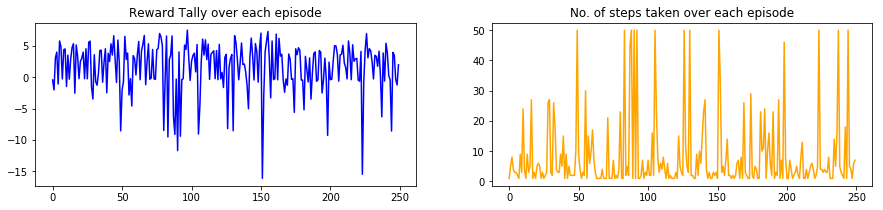

2500/2500 [==============================] - 43s 17ms/step - reward: 0.2131
done, took 260.982 seconds


In [14]:
print(f"Training for ~{episodes} episodes with max {nb_max_episode_steps} steps, logging every {log_interval} steps")
dqn_model.fit(env=env, nb_steps=nb_steps, log_interval=log_interval, nb_max_episode_steps=nb_max_episode_steps, callbacks=[plot_info])

In [15]:
#raise ValueError('temp')

TODO: Make an Asynchronous Advantage Actor-Critic A3C implementation in Keras!

References:

- [Reinforcement Learning w/ Keras + OpenAI: Actor-Critic Models](https://towardsdatascience.com/reinforcement-learning-w-keras-openai-actor-critic-models-f084612cfd69)
- [Let’s make an A3C: Implementation](https://jaromiru.com/2017/03/26/lets-make-an-a3c-implementation/)
- [Deep Reinforcement Learning Flappy Bird](https://shalabhsingh.github.io/Deep-RL-Flappy-Bird/)
- [Asynchronous Advantage Actor-Critic (A3C) (Tensorflow)](https://morvanzhou.github.io/tutorials/machine-learning/reinforcement-learning/6-3-A3C/)

### Save the DQN model!

In [16]:
dqn_model.save_weights(filepath='model/weights/dqn-model-weights.hdf5', overwrite=True)

### See how our player does

In [17]:
dqn_model.load_weights(filepath='model/weights/dqn-model-weights.hdf5')  #reload the saved dqn model weights

Testing for 1 episodes ...
  (Right)


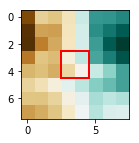

  (Right)


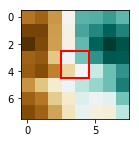

  (Right)


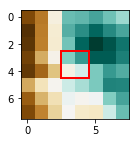

  (Right)


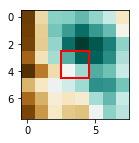

  (Right)


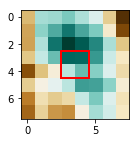

Episode 1: reward: -0.963, steps: 5
-0.9625194668769836


In [18]:
evaluation_info = dqn_model.test(env=env, nb_episodes=1, nb_max_episode_steps=5)
print(np.mean(evaluation_info.history['episode_reward']))